## Probit model
---


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display

Because the cumulative probability function of the normal distribution is not available, we define it here.

In [2]:
def normal_cdf(x):
    return 0.5 * (1.0 + pm.math.erf(x / pm.math.sqrt(2.0)))

The following cell generates data from 

$$
 y_i = \begin{cases}
 1, & \text{with probability}\quad \mu_i; \\
 0, & \text{with probability}\quad 1-\mu_i.
 \end{cases}
$$

$$
 \Phi^{-1}(\mu_i) = 0.5 x_{1i} - 0.5 x_{2i},\quad i=1,\dots,500.
$$

In [3]:
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
q = st.norm.cdf(0.5*x1 - 0.5*x2)
y = st.bernoulli.rvs(q)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [4]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
probit_model = pm.Model()
with probit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', p=normal_cdf(idx), observed=y)
n_draws = 5000
n_chains = 4
n_tune = 1000
with probit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/teruo/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.7/site-packages/theano/gof/opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "/Users/teruo/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.7/site-packages/theano/tensor/opt.py", line 6789, in local_grad_log_erfc_neg
    if not exp.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:17<00:00, 1334.47draws/s]


In [5]:
display(pm.summary(trace))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b__0,-0.055895,0.061071,0.000384,-0.173292,0.064779,27956.961753,0.999957
b__1,0.437187,0.062605,0.000387,0.318567,0.561233,26718.575203,0.999979
b__2,-0.468529,0.063547,0.000344,-0.596801,-0.346518,29731.773134,0.999989


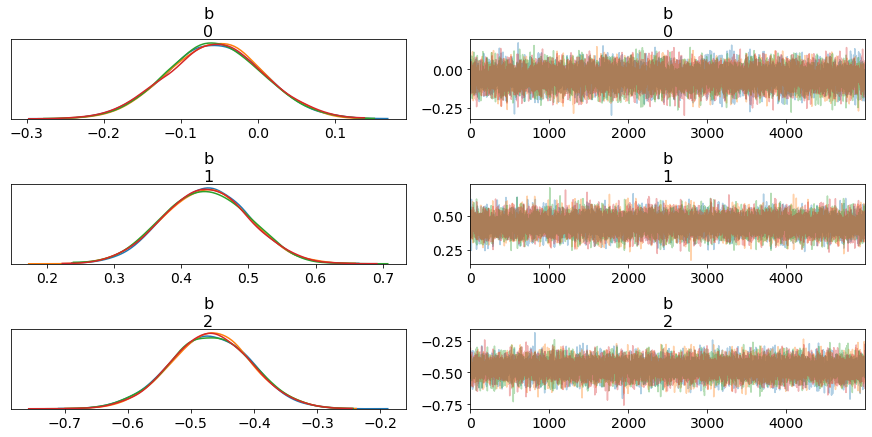

In [6]:
pm.traceplot(trace)
plt.show()

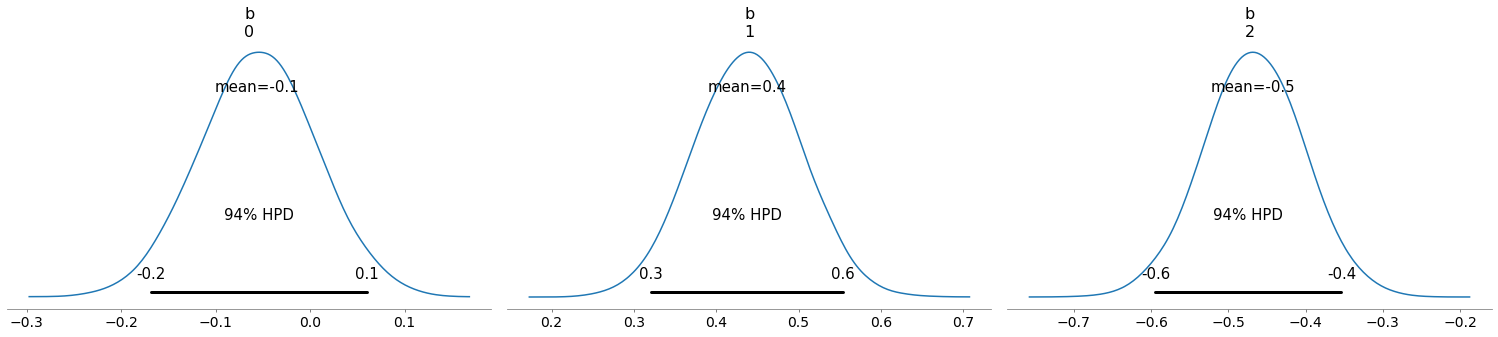

In [7]:
pm.plot_posterior(trace, kde_plot=True, point_estimate='mean')
plt.show()